# Enhancing orientations

## We need some modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import skimage.filters as flt
import skimage.io as io
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from matplotlib.patches import ConnectionPatch


## Literature
[Z. Püspöki, M. Storath, D. Sage, M. Unser 2016](https://doi.org/10.1007/978-3-319-28549-8_3)  
[Bigün 2000](link)

[Orientation demonstration](http://bigwww.epfl.ch/demo/ip/demos/orientation/)

## Analysis of orientation in structured images

In [2]:
balls = io.imread('figures/recon5s_0130.tif').astype(float)
hair  = io.imread('figures/hair.jpeg').astype(float).mean(axis=2)
pea   = io.imread('figures/peacock.jpeg').astype(float).mean(axis=2)

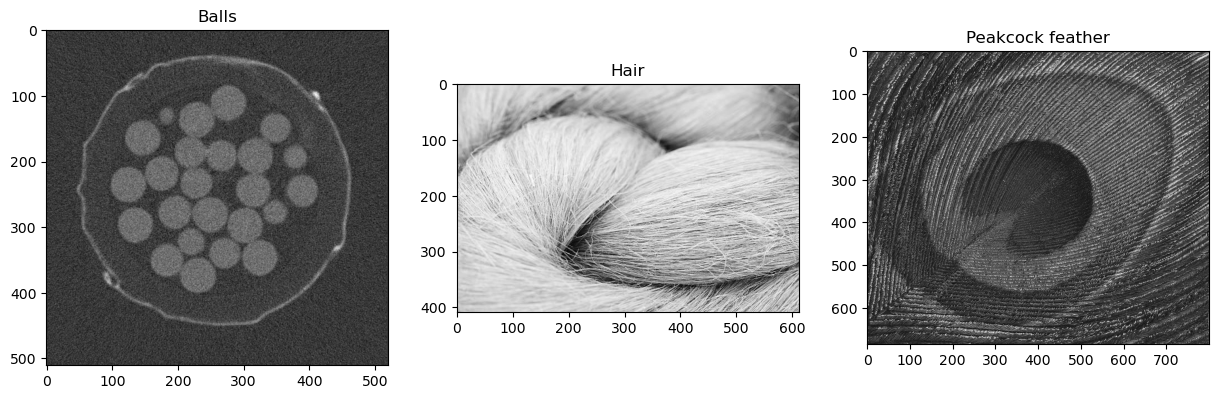

In [3]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(balls,cmap='gray')
ax[0].set_title('Balls')
ax[1].imshow(hair,cmap='gray')
ax[1].set_title('Hair')
ax[2].imshow(pea,cmap='gray')
ax[2].set_title('Peakcock feather');

### How about the Fourier transform?

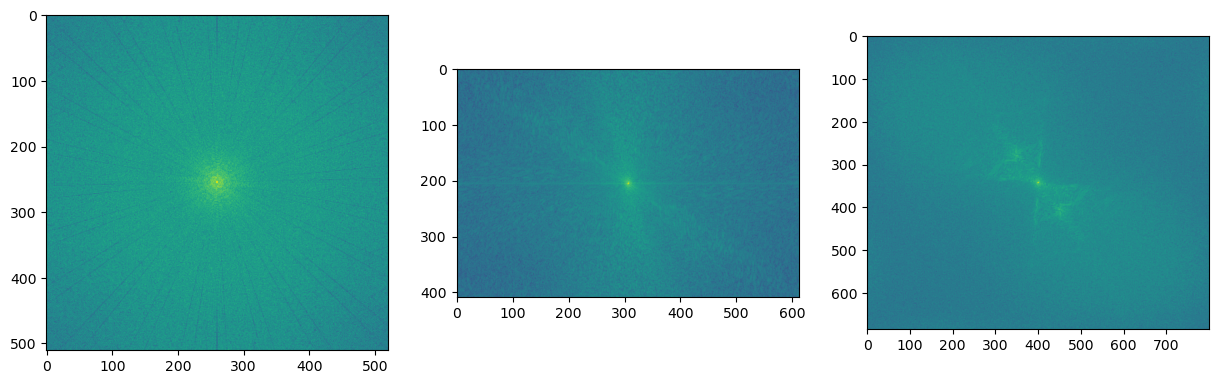

In [4]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
fballs = np.fft.fftshift(np.fft.fft2(balls));
ax[0].imshow(np.abs(fballs),norm=colors.LogNorm())

fhair = np.fft.fftshift(np.fft.fft2(hair));
ax[1].imshow(np.abs(fhair),norm=colors.LogNorm())

fpea = np.fft.fftshift(np.fft.fft2(pea));
ax[2].imshow(np.abs(fpea),norm=colors.LogNorm());

### Gradients

## The structure tensor

$$J(f) = \nabla{f} \cdot{} \nabla^T f= \left[ \begin{array}{cc}(\partial_x f)^2 & \partial_x f\cdot\partial_y f\\ \partial_y f\cdot\partial_x f & (\partial_y f)^2\end{array}\right]$$

This quite noisy information, therefore it is common to add smoothing in the computation, e.g. using a Gaussian filter.

### Implementing the structure tensor

$$J_{\sigma}(f) = G_{\sigma} * \nabla{f} \cdot{} \nabla^T f= \left[\begin{array}{cc}G_{\sigma} * (\partial_x f)^2 & G_{\sigma} * (\partial_x f\cdot\partial_y f)\\ G_{\sigma} * ( \partial_y f\cdot\partial_x f) & G_{\sigma} * (\partial_y f)^2\end{array}\right]$$

In [5]:
def structure_tensor(img,sigma) :
    Ix = gaussian_filter(img,sigma,order=[0,1]) # The Gaussian filter function can compute 
    Iy = gaussian_filter(img,sigma,order=[1,0]) # derivatives
    J = {'J11' : Ix**2,
         'J12' : Ix*Iy,
         'J21' : Ix*Iy,
         'J22' : Iy**2}
    
    return J

### Looking at the components of the structure tensor

In [6]:
J = structure_tensor(balls,1.5)

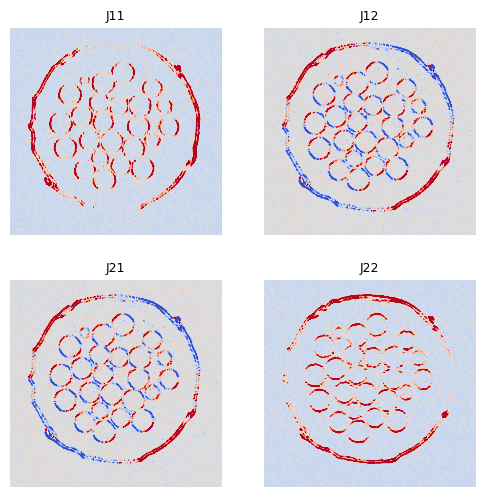

In [7]:
# Visualization
fig,axes =plt.subplots(2,2,figsize=(6,6))
axes=axes.ravel()
for ax,j in zip(axes,J) :
    m = J[j].mean()
    s = J[j].std()
    clims=[m-2*s,m+2*s]
    cmap = 'coolwarm'

    ax.imshow(J[j],clim=clims,cmap=cmap)
    ax.axis('off')
    ax.set_title(j,fontsize=9)

## Local eigen-value analysis of the structure tensor

$$\mathrm{J} \mathrm{v} = \mathrm{\lambda} \mathrm{v}$$

where $\mathrm{\lambda}$ is a diagonal matrix 
$$\mathrm{\lambda} = \left(\begin{array}{cc}\lambda_1 & 0 \\0 &\lambda_2\end{array}\right)$$


### The coherency - C

$$0\leq C = \frac{\lambda_{max}-\lambda_{min}}{\lambda_{max}+\lambda_{min}}=\frac{\sqrt{(J_{22}-J_{11})^2+4J_{12}^2}}{J_{22}+J_{11}}\leq 1$$


In [8]:
def coherency(J,eps=0.1) :
    return np.sqrt(((J['J22']-J['J11'])**2+4*J['J12']**2))/(J['J22']+J['J11']+eps)


### Looking at the coherency

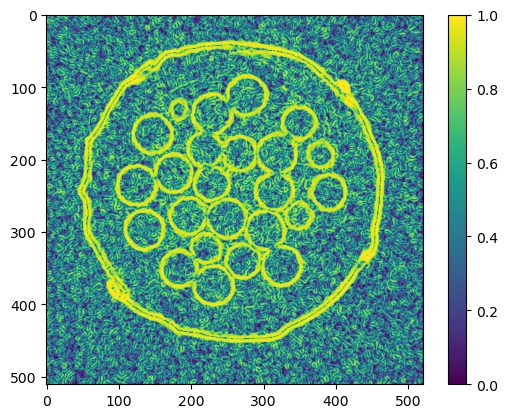

In [9]:
C=coherency(J,eps=(J['J22']+J['J11']).std()/10)
plt.imshow(C,clim=[0,1]) 
plt.colorbar()


## Local orientation angle
$$\theta=\frac{1}{2} \arctan{\left(\frac{2 J_{12}}{J_{22}-J_{11}}\right)}$$

In [10]:
def orientation_angle(J,eps=0.1) :
    return 0.5*np.arctan2(2*J["J12"],J["J22"]-J["J11"]+eps)

### Local orientations of the balls

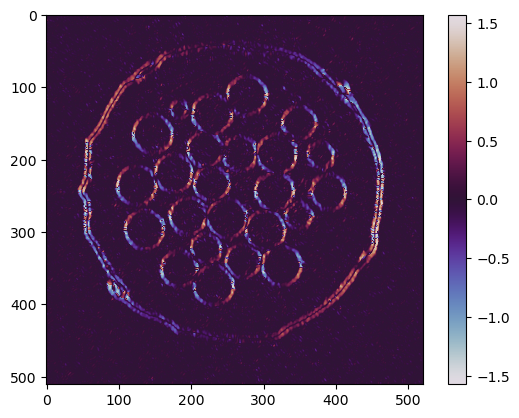

In [11]:
ang = orientation_angle(J,eps=0.01)
plt.imshow(ang,cmap='twilight')
plt.colorbar()

## An image with line structures

In [31]:
Jh = structure_tensor(hair,sigma=0.75)
Ch = coherency(Jh,eps=0.05)
Ah = orientation_angle(Jh,eps=0.1)

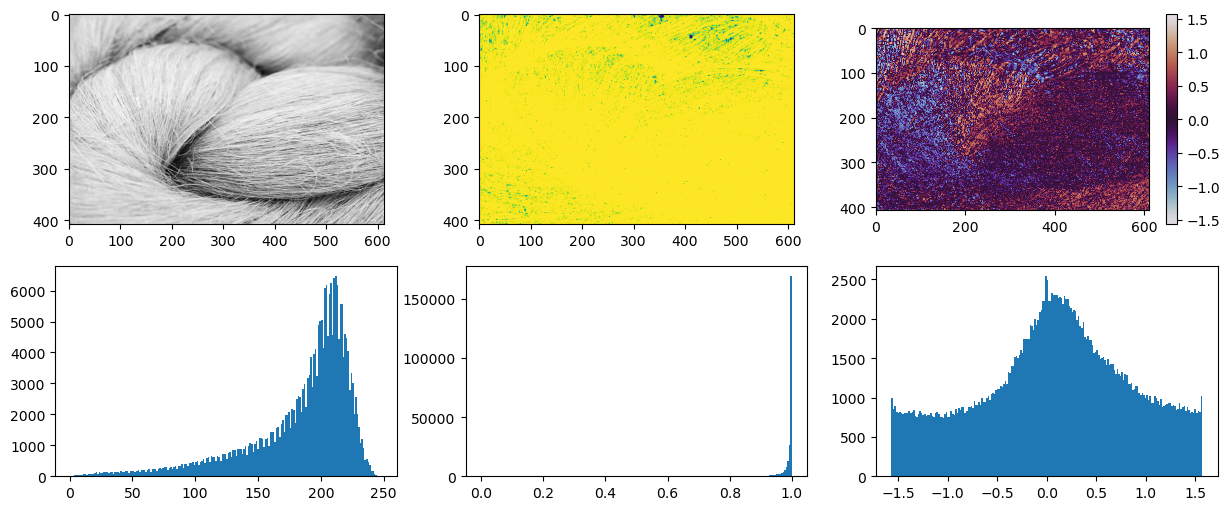

In [32]:
fig,axes = plt.subplots(2,3,figsize=(15,6))
axes = axes.ravel()

axes[0].imshow(hair,cmap='gray')
axes[1].imshow(Ch)
a2=axes[2].imshow(Ah,cmap='twilight',clim=[-np.pi/2,np.pi/2])
fig.colorbar(a2,ax=axes[2])
axes[3].hist(hair.ravel(),bins=200);
axes[4].hist(Ch.ravel(),bins=200);
axes[5].hist(Ah.ravel(),bins=200);

### How is the coherency related to the angle?

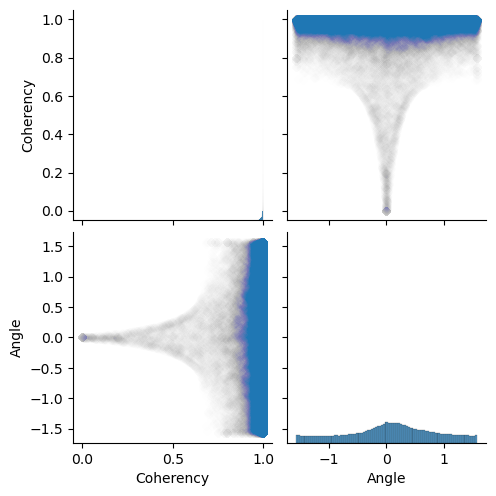

In [33]:
from seaborn import pairplot
import pandas as pd

df = pd.DataFrame({'Coherency': Ch.ravel(), 'Angle': Ah.ravel() })
pairplot(df,plot_kws=dict(alpha=0.002) );

## Compare different images with lines

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(hair,cmap='gray');
ax[0].set_title('Hair')
ax[1].imshow(pea,cmap='gray');
ax[1].set_title('Peacock feather');

### Structure tensor of the peacock feather

In [34]:
Jp = structure_tensor(pea,sigma=0.75)
Cp = coherency(Jp,eps=1)
Ap = orientation_angle(Jp,eps=0.1)

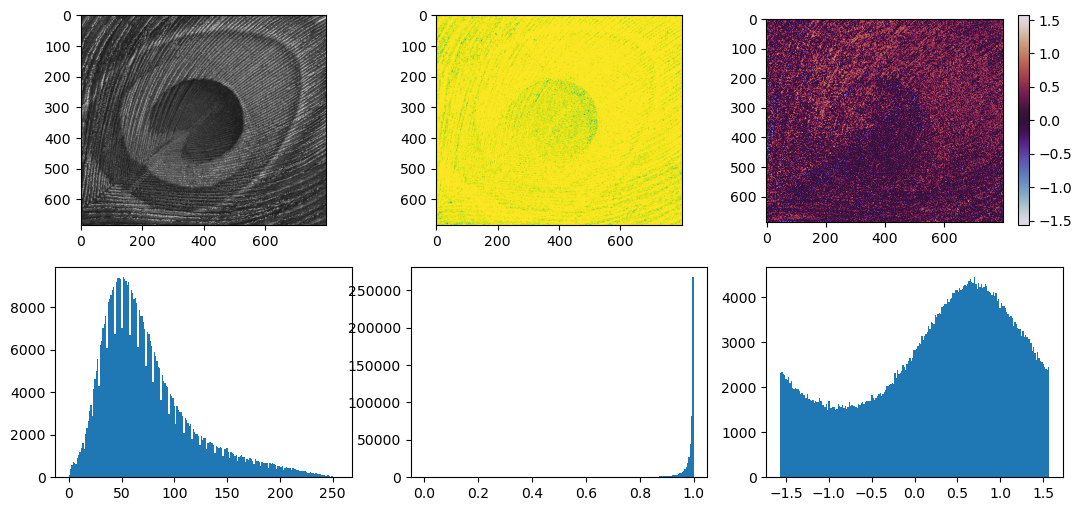

In [35]:
fig,axes = plt.subplots(2,3,figsize=(13,6))
axes = axes.ravel()

axes[0].imshow(pea,cmap='gray')
axes[1].imshow(Cp)
a2=axes[2].imshow(Ap,cmap='twilight',clim=[-np.pi/2,np.pi/2])
fig.colorbar(a2,ax=axes[2])
axes[3].hist(pea.ravel(),bins=200);
axes[4].hist(Cp.ravel(),bins=200);
axes[5].hist(Ap.ravel(),bins=200);

### Compare the orientations

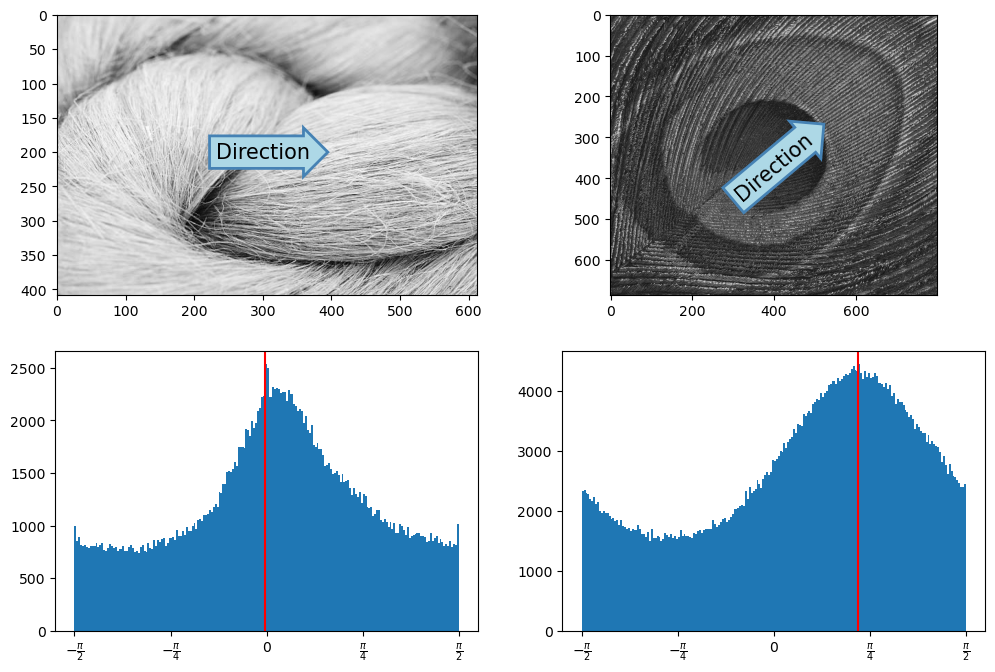

In [36]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax=ax.ravel()
ax[0].imshow(hair,cmap='gray')
t = ax[0].text(300,200,  "Direction",
            ha="center", va="center", rotation=0, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))
ax[1].imshow(pea,cmap='gray');
t = ax[1].text(400,370,  "Direction",
            ha="center", va="center", rotation=40, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))

hh=ax[2].hist(Ah.ravel(),bins=200);
ap=hh[1][np.argmax(hh[0])]
ax[2].axvline(x=ap, color='r')
ax[2].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[2].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']);

hp=ax[3].hist(Ap.ravel(),bins=200);
ap=hp[1][np.argmax(hp[0])]
ax[3].axvline(x=ap, color='r')
ax[3].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[3].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']);


### The orientation locally

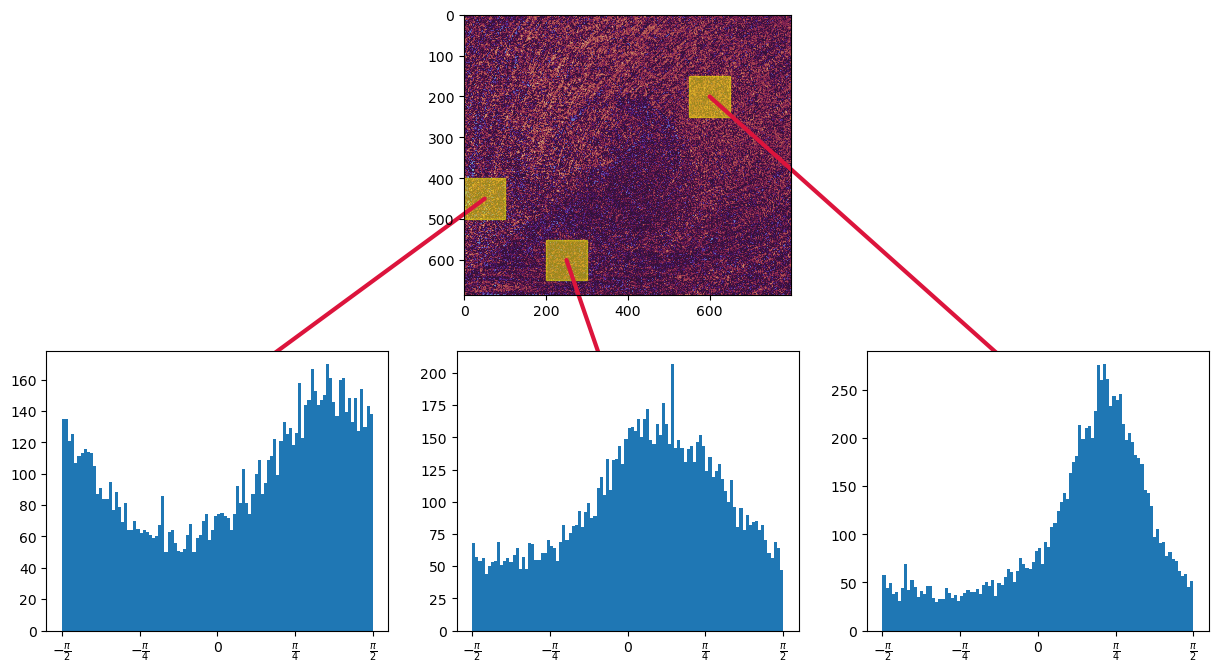

In [41]:
fig,ax = plt.subplots(2,3,figsize=(15,8))
ax=ax.ravel()
ax[0].axis('off')
ax[2].axis('off')
ax[1].imshow(Ap,cmap='twilight')

ax[3].hist(Ap[400:500,0:100].ravel(),bins=100);
ax[3].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[3].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'])

ax[4].hist(Ap[550:650,200:300].ravel(),bins=100);
ax[4].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[4].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'])

ax[5].hist(Ap[150:250,550:650].ravel(),bins=100);
ax[5].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[5].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'])



rect3 = plt.Rectangle((0,400), 100, 100, facecolor="yellow", alpha=0.5,ec="yellow")
ax[1].add_patch(rect3)



rect4 = plt.Rectangle((200,550), 100, 100,
                     facecolor="yellow", alpha=0.5,ec="yellow")
ax[1].add_patch(rect4)

rect5 = plt.Rectangle((550,150), 100, 100, facecolor="yellow", alpha=0.5,ec="yellow")
ax[1].add_patch(rect5)



con3 = ConnectionPatch(xyA=(0,150), xyB=(50,450), 
                       coordsA="data", coordsB="data", 
                       axesA=ax[3], axesB=ax[1], 
                       color="crimson", lw=3)
ax[1].add_artist(con3)

con4 = ConnectionPatch(xyA=(0,150), xyB=(250,600), 
                       coordsA="data", coordsB="data", 
                       axesA=ax[4], axesB=ax[1], 
                       color="crimson", lw=3)
ax[1].add_artist(con4)


con5 = ConnectionPatch(xyA=(0,250), xyB=(600,200), 
                       coordsA="data", coordsB="data", 
                       axesA=ax[5], axesB=ax[1], 
                       color="crimson", lw=3)
ax[1].add_artist(con5);

## Local orientations 

In [44]:
# Preparations 
# The histogram is cyclic and which will produce misleading averages
from scipy.signal import medfilt
Ap2 = Ap.copy()
Ap2[Ap2<0]=Ap2[Ap2<0]+np.pi

w=50

def local_angle(img, w) :
    res=np.zeros([1+img.shape[0]//w,1+img.shape[1]//w])

    for rr,r in enumerate(np.arange(0,img.shape[0],w)) :
        for rc,c in enumerate(np.arange(0,img.shape[1],w)) :
            h,a = np.histogram(img[r:r+w,c:c+w].ravel())
            h=medfilt(h)
            res[rr,rc]= a[np.argmax(h)]
    return res
            

Ap2avg = local_angle(Ap2,w)

r,c = np.meshgrid(np.arange(0,Ap2avg.shape[0])*w,np.arange(0,Ap2avg.shape[1])*w)
u = np.cos(Ap2avg)
v = np.sin(Ap2avg)

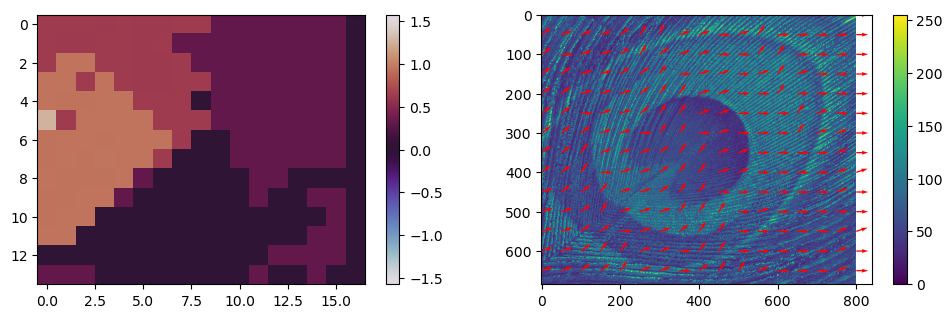

In [47]:
fig,ax = plt.subplots(1,2,figsize=(12,3.5))

a = ax[0].imshow(Ap2avg,clim=[-np.pi/2, np.pi/2],cmap='twilight')
fig.colorbar(a,ax=ax[0])
a1=ax[1].imshow(pea)
fig.colorbar(a1,ax=ax[1])
ax[1].quiver( c,r, u,v, color='red');
